<a href="https://colab.research.google.com/github/OpenXRF/openxrf.github.io/blob/main/Figure%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Starting SNR Analysis for X-ray Fluorescence Spectroscopy

📦 Installing dependencies...
📥 Cloning repository...
✅ Repository cloned successfully
✅ Libraries imported and plotting configured

📊 Dataset Information:
   • Shape: 4,753,787 rows × 18 columns
   • Columns: EventID, TrackID, ParentID, Particle, Type, Energy(MeV), Material, Process, x(mm), y(mm), z(mm), VertexX(mm), VertexY(mm), VertexZ(mm), StepLength(mm), EnergyDeposit(MeV), ProcessList, InteractionPositions(mm)
   • Energy range: 0.0 - 71.4 keV
   • Event range: 1 - 19,775,887

📋 Sample Data:
   EventID  TrackID  ParentID Particle     Type  Energy(MeV) Material  \
0        1        1         0    gamma  Primary     0.059142   G4_AIR   
1        4        1         0    gamma  Primary     0.049233   G4_AIR   
2        5        1         0    gamma  Primary     0.021864   G4_AIR   
3        7        1         0    gamma  Primary     0.059003   G4_AIR   
4        9        1         0    gamma  Primary     0.058844   G4_AIR   

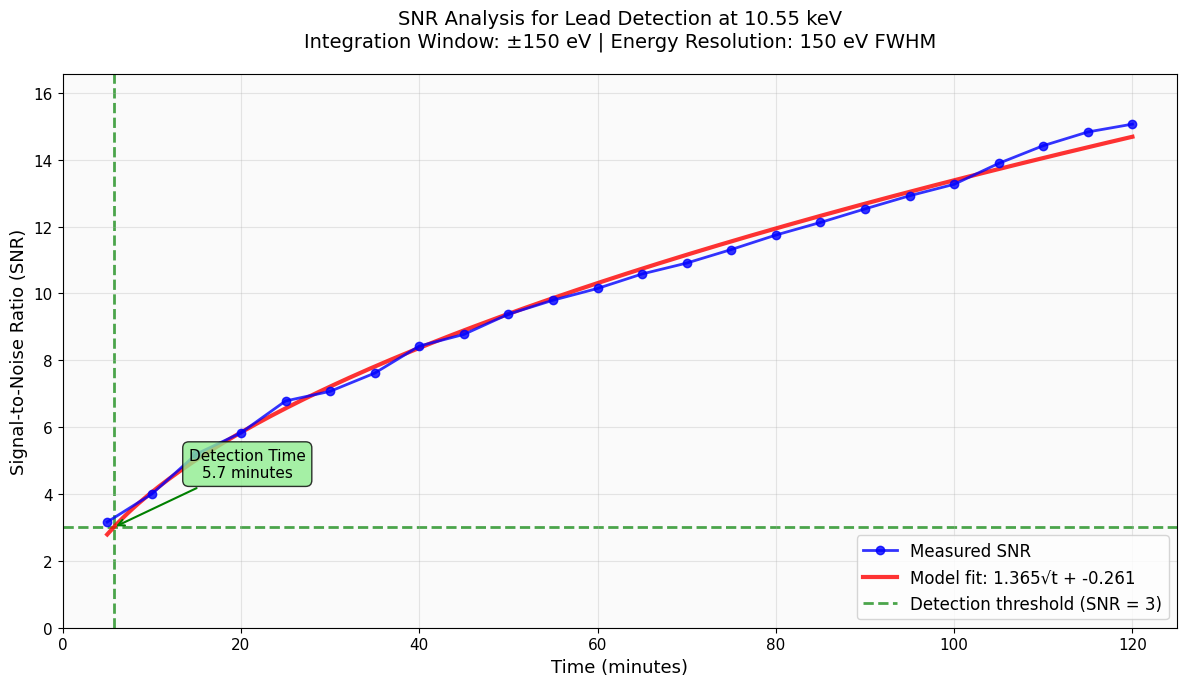


🎯 ANALYSIS RESULTS SUMMARY

📊 Dataset Characteristics:
   • Total events analyzed: 19,775,887
   • Energy range: 0.0 - 71.4 keV
   • Event types: {'Primary': 4748310, 'Secondary': 5477}

🔬 Analysis Parameters:
   • Target peak: 10.55 keV (Lead L-alpha)
   • Integration window: ±150 eV
   • Energy resolution: 150 eV FWHM
   • Time resolution: 5 minutes

📈 SNR Performance:
   • Maximum SNR achieved: 15.07
   • Final SNR (at 120 min): 15.07
   • SNR improvement factor: 4.8×

🎯 Detection Capability:
   • Time to reach SNR = 3: 5.7 minutes
   • Detection achieved: ✅ YES

📝 Key Findings:
   • SNR follows √time relationship (Poisson statistics)
   • Signal accumulates faster than noise
   • Detection capability depends on measurement time

✅ Analysis Complete! 🎉


In [1]:
# Signal-to-Noise Ratio (SNR) Analysis for X-ray Fluorescence Spectroscopy
#
# This notebook demonstrates how to calculate the Signal-to-Noise Ratio (SNR)
# over time for X-ray fluorescence peaks in soil lead detection.

print("🚀 Starting SNR Analysis for X-ray Fluorescence Spectroscopy")
print("=" * 60)

# Install dependencies and clone repository
print("\n📦 Installing dependencies...")
!pip install pandas numpy matplotlib scipy -q

print("📥 Cloning repository...")
!git clone https://github.com/OpenXRF/soil-lead-project.git -q
print("✅ Repository cloned successfully")

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

print("✅ Libraries imported and plotting configured")

# Change to repository directory and load data
os.chdir('soil-lead-project')
df = pd.read_csv('data/fig1_test.csv')

print(f"\n📊 Dataset Information:")
print(f"   • Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   • Columns: {', '.join(df.columns.tolist())}")

if 'Energy(MeV)' in df.columns:
    energy_range_keV = (df['Energy(MeV)'].min() * 1000, df['Energy(MeV)'].max() * 1000)
    print(f"   • Energy range: {energy_range_keV[0]:.1f} - {energy_range_keV[1]:.1f} keV")

if 'EventID' in df.columns:
    print(f"   • Event range: 1 - {df['EventID'].max():,}")

print(f"\n📋 Sample Data:")
print(df.head())

# Define analysis parameters
peak_energy_keV = 10.55  # Lead L-alpha peak
integration_window_eV = 150  # ±150 eV around peak
fwhm = 150  # Energy resolution in eV
step_size_min = 5  # Time step for analysis in minutes

# Convert FWHM to standard deviation
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

print(f"\n🔧 Analysis Configuration:")
print(f"   • Target peak: {peak_energy_keV} keV (Lead L-alpha)")
print(f"   • Integration window: ±{integration_window_eV} eV")
print(f"   • Energy resolution: {fwhm} eV FWHM (σ = {sigma:.1f} eV)")
print(f"   • Time resolution: {step_size_min} minutes per step")

# Add realistic energy resolution
np.random.seed(42)  # For reproducible results
df["RealisticEnergy_eV"] = np.random.normal(df["Energy(MeV)"] * 1e6, sigma)

print(f"\n✅ Applied energy resolution effects")
print(f"   • Gaussian broadening applied with FWHM = {fwhm} eV")

# Define SNR calculation function
def calculate_snr_over_time(df, peak_keV, window_eV, step_min, max_time_min=120):
    """Calculate SNR over time for a specific fluorescence peak."""

    peak_energy_eV = peak_keV * 1000
    energy_min = peak_energy_eV - window_eV
    energy_max = peak_energy_eV + window_eV

    max_events = df['EventID'].max()
    events_per_step = max_events // (max_time_min // step_min)

    time_values = []
    snr_values = []
    total_steps = max_time_min // step_min

    for step in range(1, total_steps + 1):
        current_time = step * step_min
        end_event = step * events_per_step

        # Filter data up to current time point
        df_step = df[df["EventID"] <= end_event]

        # Apply energy window filter
        df_filtered = df_step[
            (df_step["RealisticEnergy_eV"] >= energy_min) &
            (df_step["RealisticEnergy_eV"] <= energy_max) &
            (df_step["Particle"] == "gamma")
        ]

        # Count signal and background events
        if "Type" in df_filtered.columns:
            n_signal = len(df_filtered[df_filtered["Type"] == "Secondary"])
            n_background = len(df_filtered[df_filtered["Type"] == "Primary"])
        else:
            n_signal = len(df_filtered)
            n_background = int(0.1 * n_signal)

        # Calculate SNR
        total_counts = n_signal + n_background
        snr = n_signal / np.sqrt(total_counts) if total_counts > 0 else 0

        time_values.append(current_time)
        snr_values.append(snr)

        # Print progress
        if step <= 3 or step % 10 == 0:
            print(f"   t={current_time:3d} min: signal={n_signal:4d}, background={n_background:4d}, SNR={snr:.2f}")

    return time_values, snr_values

def sqrt_model(t, A, B):
    """Square root model for SNR fitting."""
    return A * np.sqrt(t) + B

# Execute main analysis
print("\n" + "=" * 50)
print("CALCULATING SNR OVER TIME")
print("=" * 50)

print(f"\n🔍 Starting SNR Analysis:")
print(f"   • Peak: {peak_energy_keV} keV")
print(f"   • Energy window: {peak_energy_keV*1000 - integration_window_eV:.0f} - {peak_energy_keV*1000 + integration_window_eV:.0f} eV")
print(f"   • Total events in dataset: {df['EventID'].max():,}")
print(f"   • Analysis duration: 2 hours (120 minutes)")
print(f"\n📈 Progress:")

time_vals, snr_vals = calculate_snr_over_time(
    df,
    peak_energy_keV,
    integration_window_eV,
    step_size_min
)

print(f"\n✅ SNR calculation completed: {len(time_vals)} time points")

# Create the plot
print(f"\n📊 Generating SNR plot...")

fig, ax = plt.subplots(figsize=(12, 7))

# Plot measured SNR data
ax.plot(time_vals, snr_vals, 'bo-', markersize=6, linewidth=2,
        alpha=0.8, label='Measured SNR', zorder=3)

# Fit square root model
detection_time = None
try:
    popt, pcov = curve_fit(sqrt_model, time_vals, snr_vals)
    x_fit = np.linspace(min(time_vals), max(time_vals), 200)
    y_fit = sqrt_model(x_fit, *popt)

    ax.plot(x_fit, y_fit, 'r-', linewidth=3, alpha=0.8,
            label=f'Model fit: {popt[0]:.3f}√t + {popt[1]:.3f}', zorder=2)

    # Calculate detection time (SNR = 3)
    if popt[0] > 0:
        time_snr3 = ((3 - popt[1]) / popt[0]) ** 2
        if 0 < time_snr3 < max(time_vals):
            ax.axhline(y=3, color='green', linestyle='--', linewidth=2,
                      alpha=0.7, label='Detection threshold (SNR = 3)', zorder=1)
            ax.axvline(x=time_snr3, color='green', linestyle='--', linewidth=2, alpha=0.7, zorder=1)

            ax.annotate(f'Detection Time\n{time_snr3:.1f} minutes',
                       xy=(time_snr3, 3), xytext=(time_snr3 + 15, 4.5),
                       fontsize=11, ha='center',
                       bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8),
                       arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

            detection_time = time_snr3

except Exception as e:
    print(f"⚠️ Could not fit curve: {e}")

# Style the plot
ax.set_xlabel('Time (minutes)', fontsize=13)
ax.set_ylabel('Signal-to-Noise Ratio (SNR)', fontsize=13)
ax.set_title(f'SNR Analysis for Lead Detection at {peak_energy_keV} keV\n'
             f'Integration Window: ±{integration_window_eV} eV | Energy Resolution: {fwhm} eV FWHM',
             fontsize=14, pad=20)

ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='lower right')
ax.set_xlim(0, max(time_vals) + 5)
ax.set_ylim(0, max(snr_vals) * 1.1)
ax.set_facecolor('#fafafa')

plt.tight_layout()
plt.show()

# Print final results
print("\n" + "=" * 60)
print("🎯 ANALYSIS RESULTS SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset Characteristics:")
print(f"   • Total events analyzed: {df['EventID'].max():,}")
print(f"   • Energy range: {df['Energy(MeV)'].min()*1000:.1f} - {df['Energy(MeV)'].max()*1000:.1f} keV")
if 'Type' in df.columns:
    type_counts = df['Type'].value_counts().to_dict()
    print(f"   • Event types: {type_counts}")

print(f"\n🔬 Analysis Parameters:")
print(f"   • Target peak: {peak_energy_keV} keV (Lead L-alpha)")
print(f"   • Integration window: ±{integration_window_eV} eV")
print(f"   • Energy resolution: {fwhm} eV FWHM")
print(f"   • Time resolution: {step_size_min} minutes")

print(f"\n📈 SNR Performance:")
print(f"   • Maximum SNR achieved: {max(snr_vals):.2f}")
print(f"   • Final SNR (at {max(time_vals)} min): {snr_vals[-1]:.2f}")
if snr_vals[0] > 0:
    print(f"   • SNR improvement factor: {snr_vals[-1]/snr_vals[0]:.1f}×")

if detection_time:
    print(f"\n🎯 Detection Capability:")
    print(f"   • Time to reach SNR = 3: {detection_time:.1f} minutes")
    print(f"   • Detection achieved: ✅ YES")
else:
    print(f"\n🎯 Detection Capability:")
    print(f"   • SNR = 3 not reached within {max(time_vals)} minutes")
    print(f"   • Detection achieved: ❌ NO (need longer acquisition)")

print(f"\n📝 Key Findings:")
print(f"   • SNR follows √time relationship (Poisson statistics)")
print(f"   • Signal accumulates faster than noise")
print(f"   • Detection capability depends on measurement time")

print(f"\n" + "=" * 60)
print("✅ Analysis Complete! 🎉")
print("=" * 60)